# Session 2: Deep Learning Frameworks.

 - One of the main advantages of taking [Keras](https://keras.io/) as a base library for neural network development is that it provides a seamless and unified access to the main Deep Learning frameworks, namely **Tensorflow, Pytorch and JAX**:

<img width="60%" src="https://s3.amazonaws.com/keras.io/img/keras_3/cross_framework_keras_3.jpg" />

These are three popular frameworks for building and deploying machine learning models. Each has unique features and strengths catering to different needs:

---

|                | **TensorFlow**                                                                                      | **PyTorch**                                                                                   | **JAX**                                                                                          |
|----------------|-----------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| **Overview**   | - Developed by Google Brain  <br> - Highly scalable and production-ready                           | - Developed by Facebook AI Research <br> - Known for ease of use and flexibility              | - Developed by Google Research <br> - Designed for high-performance machine learning research    |
| **Key Features** | - **Scalability and deployment:** Oriented to production environments <br> - **TensorBoard:** Powerful visualization and analysis tool <br> - **TF Lite & TF.js:** Deploy on mobile and web | - **Dynamic Computation Graphs:** More intuitive debugging <br> - **TorchScript:** Transition from research to production <br> - **Strong Community Support:** Numerous pre-trained models | - **Automatic Differentiation:** Efficient gradient computations <br> - **JIT Compilation:** Accelerate code using XLA <br> - **Seamless GPU/TPU Integration** |
| **Pros & Cons** | - **Pros:** Robust for large-scale applications <br> - **Cons:** Can be complex for beginners     | - **Pros:** Easy to learn; great for research <br> - **Cons:** Can be less optimized for production | - **Pros:** Extremely fast for numerical computations <br> - **Cons:** Smaller ecosystem compared to TF and PyTorch |

## How to choose a framework

 - In **80% of the cases**, the Keras API will be sufficient for not requiring any other framework-specific functionality. This allows you to change the backend at any time, just picking the one performing best.
 - Whenever you need **changing low-level details** of the code, the main question you should made is about which specific functionality you need:
   - Advanced automatic differentiation, high performance code: **JAX**.
   - Deployment on microcontrollers (TF Lite), web (TF.js), or requiring advanced visualization (TensorBoard): **Tensorflow**.
   - Easy debugging, integration of arbitrary Python code: **PyTorch**.
  
In this course, we will focus on **JAX** as our target low-level framework. Reasons:
 - **Steeper learning curve**, so better to start in a guided way. You can easily learn later PyTorch and Tensorflow in a self-taught way.
 - Is the most **mathematically elegant** framework, and better adapted for coding mathematical formulations.
 - Even if it has the smaller community, it has the **strongest momentum** among all ML frameworks.

# Crash Course on JAX

## 1. JAX: What and why?
[JAX](https://jax.readthedocs.io) is a **Python library for gradient-based Machine Learning research** developed by Google:
 - It allows in a straightforward way a very fine-grained control of model definition, training, and debugging.
 - Extremely fast, automatically manages parallelization and load distribution among CPUs, GPUs and TPUs. 
 - Designed from a [functional programming](https://en.wikipedia.org/wiki/Functional_programming) perspective.
     - JAX implementations are closer to their mathematical definition than in other frameworks.
 - **Especially convenient for early stages of ML development**
     - Perform experiments very quickly and with a full control of every element in the pipeline (data partitioning, loss functions, gradients, optimization...).
     - Basic models can then be easily scaled to state-of-the-art sizes in terms of number of parameters, dataset volume, etc.

## 2. JAX: The fundamentals

### What is Functional Programming?
- A programming paradigm focused on **mathematical functions**.
- Emphasizes **immutable data** and **pure functions**.
- Treats programs as the **composition of functions**.

#### Key Concepts
- **Immutability**: Data cannot be modified after it's created.
- **First-Class Functions**: Functions are first-class citizens, meaning they can be assigned to variables, passed as arguments, and returned from other functions.

#### Core Principles

 - **Pure Functions**
     - A function where the output is determined only by its input values.
     - No side effects (does not alter any state or data outside its scope).
 - **Higher-Order Functions**
     - Functions that take other functions as arguments or return them as results.
     - Enables powerful abstractions like `grad`, `jit`, and `vmap`.

### The JAX API

From an API point of view, JAX is basically equivalent to `numpy`. All functions in `jax.numpy` have the same signature and behavior as their counterpart in `numpy`, but they are adapted to support the three basic features of the JAX framework:

 1. **Automatic differentiation.**
 2. **Just-in-Time compilation.**
 3. **Automatic vectorization.**
 
Below we show how to use each of these features, their practical limitations, and how advanced optimization is built on top of them. Let's start with the basic setup and imports.

In [2]:
#JAX imports
import os
os.environ['JAX_PLATFORMS'] = 'cpu' #Restrict CPU usage
import jax
import jax.numpy as jnp

#Additional regular imports
import numpy as np
import matplotlib.pyplot as plt
#Figure settings to avoid super large plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 90

### 2.1 Working with automatic differentiation

 - Jax is the continuation of the [Autograd](https://github.com/hips/autograd) library.
 - Can automatically differentiate almost any Python and NumPy code you may have.
 - Supports conditionals, loops, recursion and closures, and can calculate higher-order derivatives. Both **reverse-mode and forward-mode differentiation** are implemented.

Two basic functions for automatic differentiation: [`jax.grad()`](https://docs.jax.dev/en/latest/_autosummary/jax.grad.html) and [`jax.value_and_grad()`](https://docs.jax.dev/en/latest/_autosummary/jax.value_and_grad.html):
 - Both receive a function and **return another function**.

Let's start with a basic example:

In [6]:
def f(x, y):
    return x+y**2

df = jax.grad(f)

print(f"Gradient of f at (2,2): {df(2., 2.)}")

Gradient of f at (2,2): 1.0


🤔 The result is a bit surprising, since the function `f` has two input variables, and thus we would expect a 2-value gradient vector. 
 - By default, `grad()` only evaluates the **gradient with respect to the first argument**.
 - If we want to differentiate with respect to more arguments, we need to modify the `argnums` parameter:

In [7]:
dfy = jax.grad(f, 1)
dfxy = jax.grad(f, (0, 1))

print(f"Gradient of f with respect to y at (2,2): {dfy(2., 2.)}")
print(f"Gradient of f with respect to x and y at (2,2): {np.array(dfxy(2., 2.))}")

Gradient of f with respect to y at (2,2): 4.0
Gradient of f with respect to x and y at (2,2): [1. 4.]


`jax.grad()` is flexible enough to support very complex and entangled Python constructs:

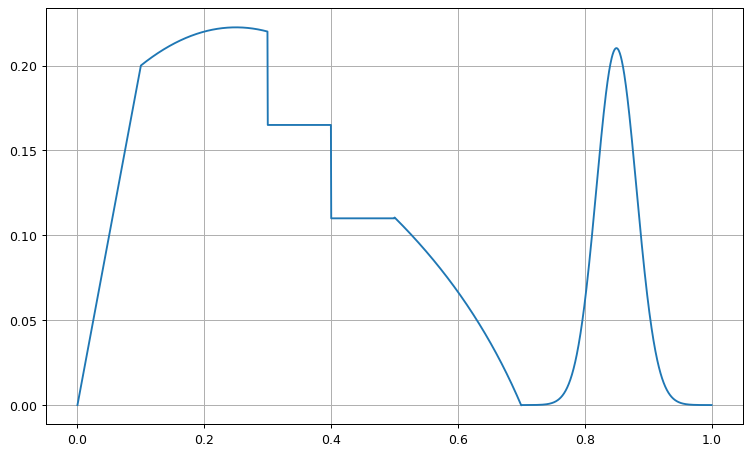

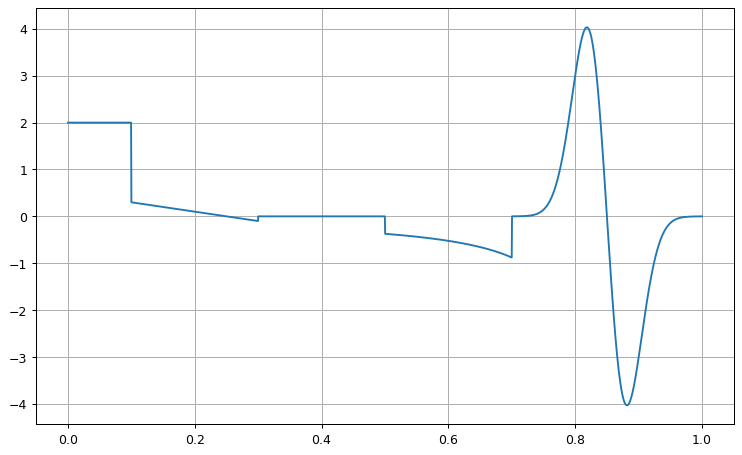

In [8]:
def f_tangled(x):
    if 0 <= x <= 1:
        if x < 0.1:
            return 2*x
        if x < 0.3:
            return 0.2225-(x-0.25)**2
        for i in range(2):
            if (x-0.3)//0.1 == i:
                return 0.165 if i==0 else f_tangled(x-0.1)-0.055
        if x < 0.7:
            x = 0.5+(x-0.5)*1.4412477
            return 0.2+jnp.log(1-x)/7.75
        return jax.scipy.stats.multivariate_normal.pdf(x, 0.85, 0.001)/60
    return 0

X = np.linspace(0, 1, 2000)
plt.plot(X, [f_tangled(x) for x in X])
plt.grid()
plt.figure()
df_tangled = jax.grad(f_tangled)
plt.plot(X, [df_tangled(x) for x in X])
plt.grid()

By convention, in Jax the functions to be differentiated (typically loss functions) declare a **first argument which groups all the parameters involved in gradient calculation**, and for the rest of the arguments the gradients are not calculated (e.g., the true labels of a mini-batch). 
 - This first argument is usually a `jax.numpy` array or a dictionary of named arrays. This is illustrated below in section 3.

### 2.2 Just-in-Time Compilation

The second pillar that makes JAX such a convenient tool for ML model development is the just-in-time compilation of code for multiple devices (CPU, GPU, TPU). 
 - The main entry point to this functionality is `jax.jit()`, that can be used both as a function or as a decorator `@jax.jit`.
 
Let's run a basic example with a function that computes the Euclidean pairwise distances on an N-dimensional dataset with M samples:

In [9]:
def pairwise_distances(X):
    M = X.shape[0]
    N = X.shape[1]
    D = jnp.empty((M, M))
    for i in range(M):
        for j in range(M):
            d = 0.0
            for k in range(N):
                tmp = X[i, k] - X[j, k]
                d += tmp * tmp
            D = D.at[i, j].set(jnp.sqrt(d))
    return D

pw_distances_compiled = jax.jit(pairwise_distances)

#Basic check to ensure that the result is the same in both functions
X = np.array([[0, 1], [1, 0], [2, 0]])
np.allclose(pairwise_distances(X), pw_distances_compiled(X), atol=1e-6)

True

We check how faster the compiled version can be:

In [10]:
%timeit pairwise_distances(X)
%timeit pw_distances_compiled(X)

2.5 ms ± 30.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.21 µs ± 65.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


However, this amazing speedup **does not come for free**. While being as easy to use as `jax.grad()`, `jax.jit()` imposes several **constraints** in order to optimize our code as much as possible. The following table summarizes which Python constructs we can use safely in our functions, and which ones we should be careful about:

\begin{split}
\begin{array} {r|rr} 
\hline \
\textrm{construct} 
& \textrm{jit} 
& \textrm{grad} \\
\hline \
\textrm{if} & ❌ & ✔ \\
\textrm{for} & ✔* & ✔\\
\textrm{while} & ✔* & ✔\\
\textrm{lax.cond} & ✔ & ✔\\
\textrm{lax.while\_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.fori\_loop} & ✔ & \textrm{fwd}\\
\textrm{lax.scan} & ✔ & ✔\\
\hline
\end{array}
\end{split}
$\ast=$ argument-**value**-independent loop condition - unrolls the loop

 - Classical control flow constructs (**if**, **for** and **while**) can be troublesome for `jit` compilation.
     -  Jax provides some functional alternatives in the `jax.lax` package.
   
💡 As a functional framework, the rule of thumb would when programming in Jax is:

 - *Avoid any control flow in your code, and just write it as a sequence of calls to `jax.*` functions.*

### Why do these constraints exist?

When executing eagerly (outside of `jit`), Jax code works with Python control flow and logical operators just like Numpy code. But using control flow and logical operators with `jit` is more complicated. 

The JIT transformation is fundamentally different to `grad` or `vmap`:
 - The resulting functions **are no longer Python functions**.
 - Each function is converted into a sequence of `primitive` operations, each representing one fundamental unit of computation, in an intermediate language called [`jaxpr`](https://docs.jax.dev/en/latest/jaxpr.html#jax-internals-jaxpr).

One way to see the sequence of primitives behind a function is using `jax.make_jaxpr`:

In [11]:
global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In a nutshell:
 - Python control flow and logical operators are evaluated at JIT compile time and translated into `jaxpr`.
 - The compiled function represents **a single path** through the [control flow graph](https://en.wikipedia.org/wiki/Control-flow_graph) (logical operators affect the path via short-circuiting).
 - If the path depends on the values of the inputs, the function (by default) cannot be JIT compiled.
 - The path may depend on the shape or dtype of the inputs, and **the function is re-compiled every time it is called on an input with a new shape or dtype.**

For example, this works:

In [24]:
@jax.jit
def f(x):
  for i in range(3):
    x = 2 * x
  return x

print(f(3))

24


So does this:

In [25]:
@jax.jit
def g(x):
  y = 0.
  for i in range(x.shape[0]):
    y = y + x[i]
  return y

print(g(jnp.array([1., 2., 3.])))

6.0


But this doesn't, at least by default:

In [17]:
@jax.jit
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

# This will fail!
f(2)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at /tmp/ipykernel_5316/3967699706.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

Neither does this:

In [18]:
@jax.jit
def g(x):
  return (x > 0) and (x < 3)

# This will fail!
g(2)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function g at /tmp/ipykernel_5316/3483164813.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://docs.jax.dev/en/latest/errors.html#jax.errors.TracerBoolConversionError

When we `jit`-compile a function, we usually want to compile a version of the function that works for many different argument values, so that we can reuse the compiled code.

For example, if we evaluate an `@jit` function on the array `jnp.array([1., 2., 3.], jnp.float32)`, we want to compile code that we can reuse to evaluate the function on `jnp.array([4., 5., 6.], jnp.float32)`.

To get a view of your Python code that is valid for many different argument values, **JAX traces it with the `ShapedArray` abstraction as input**.
 - Each abstract value represents the set of all array values with a fixed shape and dtype.

For example, if we trace using the abstract value `ShapedArray((3,), jnp.float32)`, we get a view of the function that can be reused for any array with 3 elements in 1 dimension.

But there's a tradeoff here: if we trace a Python function on a `ShapedArray((), jnp.float32)` that isn't committed to a specific concrete value, when we hit a line like `if x < 3`, the expression `x < 3` evaluates to an abstract `ShapedArray((), jnp.bool_)` that represents the set `{True, False}`. When Python attempts to coerce that to a concrete `True` or `False`, we get an error: we don't know which branch to take, and can't continue tracing!

Good news: You can control this tradeoff to a certain extent:
 - Using the `static_argnames` (or `static_argnums`) argument to `jit`, we can specify to trace on concrete values of some arguments. Here's that example function again:

In [26]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jax.jit(f, static_argnames='x')

print(f(2.))

12.0


Here's another example, this time involving a loop:

In [27]:
def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

f = jax.jit(f, static_argnames='n')

f(jnp.array([2., 3., 4.]), 2)

Array(5., dtype=float32)

In effect, the loop gets statically unrolled.

️⚠️ **functions with argument-__value__ dependent shapes**

These control-flow issues also come up in a more subtle way: numerical functions we want to __jit__ can't specialize the shapes of internal arrays on argument _values_ (specializing on argument __shapes__ is ok).  As a trivial example, let's make a function whose output happens to depend on the input variable `length`.

In [28]:
def example_fun(length, val):
  return jnp.ones((length,)) * val
# un-jit'd works fine
print(example_fun(5, 4))

bad_example_jit = jax.jit(example_fun)
# this will fail:
bad_example_jit(10, 4)

[4. 4. 4. 4. 4.]


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace>,).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function example_fun at /tmp/ipykernel_5316/921785482.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument length.

In [29]:
# static_argnames tells JAX to recompile on changes at these argument positions:
good_example_jit = jax.jit(example_fun, static_argnames='length')
# first compile
print(good_example_jit(10, 4))
# recompiles
print(good_example_jit(5, 4))

[4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
[4. 4. 4. 4. 4.]


`static_argnames` can be handy if `length` in our example rarely changes, but it **would be disastrous** if it changed a lot!

#### 📋 Exercise 1

The function below `do_segments_intersect()` calculates whether two 2D segments intersect or not. Provide a new implementation compatible with `@jax.jit`.

__Hints:__
 - Start by making `orientation()` and `on_segment()` jit-compatible.
     - [`jnp.sign()`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.sign.html) may be useful!
 - Any sequence of logical checks can be represented as a composition of [`jnp.logical_and()`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.logical_and.html) and [`jnp.logical_or()`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.logical_and.html) calls.


True


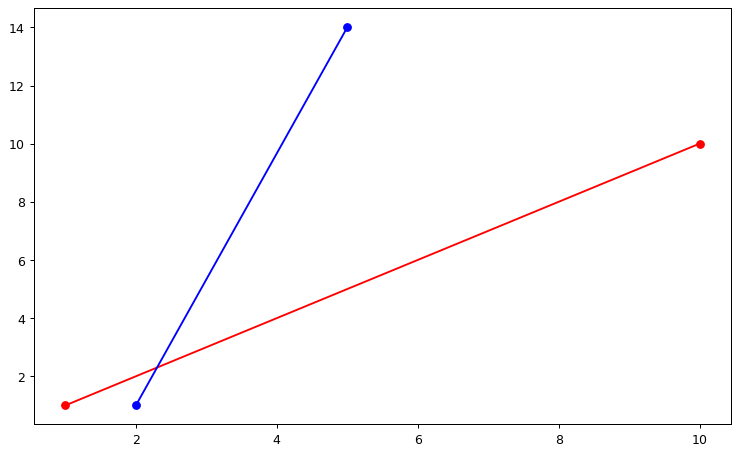

In [12]:
def do_segments_intersect(p1, q1, p2, q2):
    """
    Function that checks if two segments in 2D intersect. Each segment is defined by two 
    points `p` and `q`. Each point is assumed to be an array with two components (x,y).
    """
    # Helper function to find orientation of ordered triplet (p, q, r).
    # Returns the following values:
    # 0 -> p, q and r are collinear
    # 1 -> Clockwise
    # 2 -> Counterclockwise
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        if val == 0:
            return 0
        return 1 if val > 0 else 2

    # Helper function to check if point q lies on line segment 'pr'
    def on_segment(p, q, r):
        if (min(p[0], r[0]) <= q[0] <= max(p[0], r[0]) and
                min(p[1], r[1]) <= q[1] <= max(p[1], r[1])):
            return True
        return False

    # Find the orientations needed for the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # General case
    if o1 != o2 and o3 != o4:
        return True

    # Special cases
    # p1, q1, and p2 are collinear and p2 lies on segment p1q1
    if o1 == 0 and on_segment(p1, p2, q1):
        return True

    # p1, q1, and q2 are collinear and q2 lies on segment p1q1
    if o2 == 0 and on_segment(p1, q2, q1):
        return True

    # p2, q2, and p1 are collinear and p1 lies on segment p2q2
    if o3 == 0 and on_segment(p2, p1, q2):
        return True

    # p2, q2, and q1 are collinear and q1 lies on segment p2q2
    if o4 == 0 and on_segment(p2, q1, q2):
        return True

    # If none of the cases apply, the segments do not intersect
    return False

# Example usage:
p1, q1 = jnp.array([[1, 1], [10, 10]])
p2, q2 = jnp.array([[2, 1], [5, 14]])

plt.plot([p1[0], q1[0]], [p1[1],q1[1]], 'ro-')
plt.plot([p2[0], q2[0]], [p2[1],q2[1]], 'bo-')
print(do_segments_intersect(p1, q1, p2, q2))

True
1.51 ms ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.19 µs ± 104 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


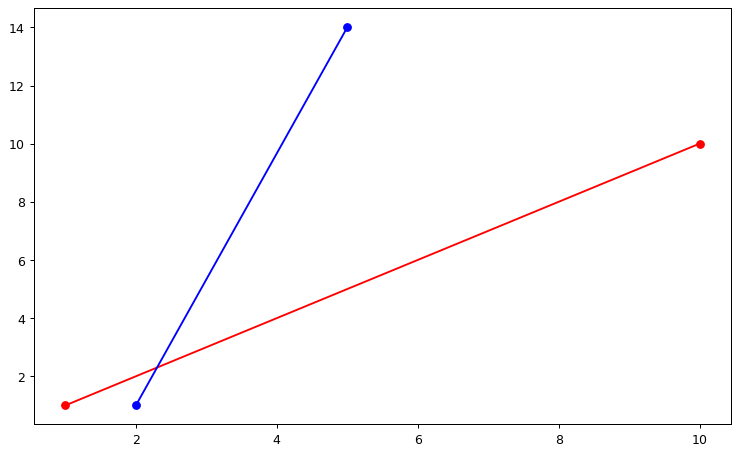

In [13]:
#Complete the code to solve Exercise 1:
@jax.jit
def do_segments_intersect_jittable(p1, q1, p2, q2):
    """
    Function that checks if two segments in 2D intersect. Each segment is defined by two 
    points `p` and `q`. Each point is assumed to be an array with two components (x,y).
    """
    # Helper function to find orientation of ordered triplet (p, q, r).
    # Returns the following values:
    #  0 -> p, q and r are collinear
    #  1 -> Clockwise
    # -1 -> Counterclockwise
    def orientation(p, q, r):
        val = (q[1] - p[1]) * (r[0] - q[0]) - (q[0] - p[0]) * (r[1] - q[1])
        return jnp.sign(val)

    # Helper function to check if point q lies on line segment 'pr'
    def on_segment(p, q, r):
        c1 = jnp.logical_and(jnp.min(jnp.array([p[0],r[0]])) <= q[0], 
                             q[0] <= jnp.max(jnp.array([p[0],r[0]])))
        c2 = jnp.logical_and(jnp.min(jnp.array([p[1],r[1]])) <= q[1], 
                             q[1] <= jnp.max(jnp.array([p[1],r[1]])))
        return jnp.logical_and(c1, c2)

    # Find the orientations needed for the general and special cases
    o1 = orientation(p1, q1, p2)
    o2 = orientation(p1, q1, q2)
    o3 = orientation(p2, q2, p1)
    o4 = orientation(p2, q2, q1)

    # General case
    cg = jnp.logical_and(o1 != o2, o3 != o4)
    #Special cases
    # p1, q1, and p2 are collinear and p2 lies on segment p1q1
    cs1 = jnp.logical_and(o1 == 0, on_segment(p1, p2, q1))
    # p1, q1, and q2 are collinear and q2 lies on segment p1q1
    cs2 = jnp.logical_and(o2 == 0, on_segment(p1, q2, q1))
    # p2, q2, and p1 are collinear and p1 lies on segment p2q2
    cs3 = jnp.logical_and(o3 == 0, on_segment(p2, p1, q2))
    # p2, q2, and q1 are collinear and q1 lies on segment p2q2
    cs4 = jnp.logical_and(o4 == 0, on_segment(p2, q1, q2))

    return jnp.logical_or(jnp.logical_or(jnp.logical_or(jnp.logical_or(cg, cs1), cs2), cs3), cs4)

# Example usage:
p1, q1 = jnp.array([[1, 1], [10, 10]])
p2, q2 = jnp.array([[2, 1], [5, 14]])

plt.plot([p1[0], q1[0]], [p1[1],q1[1]], 'ro-')
plt.plot([p2[0], q2[0]], [p2[1],q2[1]], 'bo-')
print(do_segments_intersect_jittable(p1, q1, p2, q2))

#Compare execution times with and without jit.
%timeit do_segments_intersect(p1, q1, p2, q2)
%timeit do_segments_intersect_jittable(p1, q1, p2, q2)

### 2.3 Auto-Vectorization

Last, but not least, JAX provides the [`jax.vmap`](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html) transformation, which performs automatic vectorization of functions. 
 - Allows you to compute the output of a function **in parallel over some axis of the input**, making it extremely convenient for use cases such as:
     - You can develop your functions **assuming a scalar input**, and they will automatically work with multidimensional inputs.
     - A loss function that is calculated for a single example can be directly transformed to work with *batches*.
 
This functionality is similar to that provided by `numpy.vectorize`, but the [semantics are different](https://stackoverflow.com/questions/69099847/jax-vectorization-vmap-and-or-numpy-vectorize), and it is much [more efficient](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.vectorize.html).

As a basic example, let's assume we have a trained logistic regression model with fixed coefficients and intercept, and we define the following function to estimate the probability of a new sample:

In [57]:
def predict_proba(sample):
    coefs = jnp.array([-0.44501376,  0.89999242, -2.32353827, -0.97345836])
    intercept = 6.69040651
    score = jnp.dot(coefs, sample) + intercept
    return jax.nn.softmax(jnp.array([-score, score]))[0]

#Array of samples
X = np.array([[5.2, 4.1, 1.5, 0.1],
              [5.7, 3.8, 1.7, 0.3],
              [5.5, 2.6, 4.4, 1.2],
              [6.3, 2.7, 4.9, 1.8],
              [5.9, 3. , 4.2, 1.5],
              [5. , 2.3, 3.3, 1. ],
              [5.7, 2.6, 3.5, 1. ],
              [6.2, 3.4, 5.4, 2.3]])

#We can predict the probability of a single sample
print(f'Probability of the first sample: {predict_proba(X[0]):.8f}')

Probability of the first sample: 0.00012750


But if we try to apply the function to the full set of samples...

In [58]:
print(predict_proba(X))

TypeError: dot_general requires contracting dimensions to have the same shape, got (4,) and (8,).

So we vectorize the function with `vmap()` to support this. We also compare the performance gain with respect to using a Python loop, and the additional benefits that `jit()` can provide.

In [59]:
vpredict_proba = jax.vmap(predict_proba)
print(vpredict_proba(X))
%timeit [predict_proba(sample) for sample in X]
%timeit vpredict_proba(X)
#The function can be also jitted for further efficiency
vpredict_proba_compiled = jax.jit(vpredict_proba)
%timeit vpredict_proba_compiled(X)

[1.2749569e-04 1.2750516e-03 9.9993348e-01 9.9999881e-01 9.9986482e-01
 9.8539424e-01 9.9464345e-01 9.9999988e-01]
2.06 ms ± 57.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.23 ms ± 51.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.78 µs ± 64.3 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The use of `vmap` is trivial when we only want to vectorize with respect to a single axis, but it may become complex if the vectorized function works with several multi-dimensional arguments.
 - In these cases, you should rely on the composition of multiple `vmap`. 
     - A proper definition of the **`in_axes` parameter** is fundamental. This is the documentation for that parameter, which can be rather confusing 🤯:
```
in_axes (int | None | Sequence[Any])

An integer, None, or sequence of values specifying which input array axes to map over.

If each positional argument to fun is an array, then in_axes can be an integer, a None, or a tuple of integers and Nones with length equal to the number of positional arguments to fun. An integer or None indicates which array axis to map over for all arguments (with None indicating not to map any axis), and a tuple indicates which axis to map for each corresponding positional argument. Axis integers must be in the range [-ndim, ndim) for each array, where ndim is the number of dimensions (axes) of the corresponding input array.

If the positional arguments to fun are container (pytree) types, in_axes must be a sequence with length equal to the number of positional arguments to fun, and for each argument the corresponding element of in_axes can be a container with a matching pytree structure specifying the mapping of its container elements. In other words, in_axes must be a container tree prefix of the positional argument tuple passed to fun. See this link for more detail: https://docs.jax.dev/en/latest/pytrees.html#applying-optional-parameters-to-pytrees

Either axis_size must be provided explicitly, or at least one positional argument must have in_axes not None. The sizes of the mapped input axes for all mapped positional arguments must all be equal.

Arguments passed as keywords are always mapped over their leading axis (i.e. axis index 0).
```

As an example, let's implement the functionality provided by the `pairwise_distance()` function above using as basis the function to calculate the distance between two points, and then using `vmap` to vectorize it over the two dimensions.

In [74]:
def dist(x, y):
    return jnp.linalg.norm(x-y)

X = np.array([[0, 1], [1, 0], [2, 0]])

print(f'Distance between points 0 and 1: {dist(X[0], X[1])}')

#With vmap, we can calculate the distance from one point to all the others (the first argument is not vectorized)
y_vmap_dist = jax.vmap(dist, in_axes=(None, 0))
print(f'Distance between point 0 and all others: {y_vmap_dist(X[0], X)}')

#With a second vmap, we can vectorize with respect to the first argument as well, achieving all-pairs functionality
xy_vmap_dist = jax.vmap(y_vmap_dist, in_axes=(0, None))
print(f'Distance between all pairs: \n{xy_vmap_dist(X, X)}')

#Finally, we jit the function and set the interface to be the same as for previous implementations.
j_vmap_dist = jax.jit(lambda X:xy_vmap_dist(X, X))

%timeit j_vmap_dist(X)

Distance between points 0 and 1: 1.4142135381698608
Distance between point 0 and all others: [0.        1.4142135 2.236068 ]
Distance between all pairs: 
[[0.        1.4142135 2.236068 ]
 [1.4142135 0.        1.       ]
 [2.236068  1.        0.       ]]
5.27 µs ± 40.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### 📋 Exercise 2

Consider the function `do_segments_intersect_jitted()` developed in Exercise 2.2.1. By means of `vmap`, provide new functions that:
 1. Calculate if a segment intersect a list of other segments.
 2. Calculate, given a list of segments, if there is any intersection between a pair of segments (ignoring intersections of a segment with itself).

In [87]:
#We create 10 random segments with points P and Q. First segment is from P[0] to Q[0],
# second segment from P[1] to Q[1], etc.
P = np.array([[0.62267741, 0.36057143],
              [0.76362257, 0.80168211],
              [0.40162121, 0.97281945],
              [0.44615934, 0.6005011 ],
              [0.82299275, 0.98081328],
              [0.76234926, 0.72984573],
              [0.75754731, 0.04326656],
              [0.37916813, 0.69457057],
              [0.76666871, 0.72114398],
              [0.26649429, 0.66837848]])
Q = np.array([[0.05325263, 0.0749455 ],
              [0.6288506 , 0.54228588],
              [0.01499495, 0.76980637],
              [0.81286603, 0.71454098],
              [0.50154957, 0.00097182],
              [0.77598633, 0.61250293],
              [0.75234872, 0.77697743],
              [0.96807352, 0.13413568],
              [0.88151223, 0.73528023],
              [0.55853233, 0.44841296]])

#1. Definition of a function that allows to calculate intersection from one segment to an
#array of other segments.
intersect_vmp = jax.vmap(do_segments_intersect_jittable, (None, None, 0, 0))
#We check the intersections with the first segment
print(intersect_vmp(P[0], Q[0], P[1:], Q[1:]))
%timeit intersect_vmp(P[0], Q[0], P[1:], Q[1:])
%timeit jax.jit(intersect_vmp)(P[0], Q[0], P[1:], Q[1:])

#2. Function to calculate intersections between a group of segments.
def pairwise_intercept(P, Q):
    pw_map = jax.vmap(intersect_vmp, (0, 0, None, None))
    interc_matrix = pw_map(P, Q, P, Q).astype(int)
    return jnp.sum(interc_matrix) > len(P)
print(pairwise_intercept(P, Q)) # This should return True
%timeit pairwise_intercept(P, Q)
%timeit jax.jit(pairwise_intercept)(P, Q)
print(pairwise_intercept(P,P)) # This should return False

[False False False  True False False False False False]
273 µs ± 7.99 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
59.7 µs ± 2.15 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
True
545 µs ± 5.14 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
42.5 µs ± 1.13 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Array(False, dtype=bool)

#### 📋 Exercise 3

Using the following function definition:
```python
def prod(a,b):
    return a*b
    
```

, and exclusively `vmap`, provide the following functionality:
 - Given vectors `va` and `vb`, calculate their [outer product](https://en.wikipedia.org/wiki/Outer_product). The result has to be equal to that provided by [`jnp.outer()`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.outer.html).
 - Given two batches of vectors of equal size, [$va_0, \ldots, va_n$], and [$vb_0, \ldots, vb_n$], calculate the outer product of every pair $va_i \otimes vb_i$ of vectors in the same position within the batches.



In [5]:
# Complete the code to provide a solution to Exercise 3:
def prod(a, b):
    return a*b

#Definition of two random vectors of size 10
va, vb = np.random.rand(10), np.random.rand(10)
#Definition of two batches of vectors, each one with 100 vectors
batch_a, batch_b = np.random.rand(100, 10), np.random.rand(100, 10)
#Outer product calculation by means of `prod` and `vmap`.
outer = jax.vmap(jax.vmap(prod, (None, 0)), (0, None))(va,vb)
print(jnp.allclose(outer, jnp.outer(va,vb)))
#Batched outer product of vectors.
batched_outer = jax.vmap(jax.vmap(jax.vmap(prod, (None, 0)), (0, None)), (0, 0))
print(jnp.allclose(jnp.array([jnp.outer(batch_a[i], batch_b[i]) for i in range(len(batch_a))]), 
                   batched_outer(batch_a, batch_b)))

True
True


## 3. Gradient-based optimization: Optax

While the basic functionality of JAX is fundamentally oriented to **autograd+acceleration**, there is a very active and growing ecosystem that provides all the core components required to **optimize parametric models**. In particular, the first library we will probably require in practical problems is [Optax](https://optax.readthedocs.io/en/latest/index.html): the gradient processing and optimization library for JAX.

### 3.1 Getting started with Optax

To start working with Optax, we basically require two elements:
 - An objective function to be optimized. This is typically a **loss function** calculated on the model parameters that will be minimized through gradient descent, and therefore has to be differentiable.
 - An optimizer, which is the component in charge of processing the gradients and **calculate a new value for the target parameters**. This optimizer is usually executed in an iterative fashion.
 
Optax provides a comprehensive catalog of both [losses](https://optax.readthedocs.io/en/latest/api/losses.html) and [optimizers](https://optax.readthedocs.io/en/latest/api/optimizers.html), which can be recombined and composed with our own functions, making it possible to combine low level ingredients into custom optimisers (or other gradient processing components).

Let's take a look at the typical Optax pipeline by implementing [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) in the Iris dataset:

In [2]:
import optax
#Dataset and utilities
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

@jax.jit
def loss(params, X, y):
    """Loss function (binary cross-entropy)."""
    #The model is represented by two arrays of parameters: 'coef' and 'intercept', stored
    #in a dictionary with these two keys.
    logits = jnp.log(jax.nn.sigmoid(jnp.dot(X, params['coef']) + params['intercept']))
    return optax.sigmoid_binary_cross_entropy(logits, y).mean()


def fit(params, optimizer, Xtrain, ytrain, epochs=1000):
    """Training function"""
    opt_state = optimizer.init(params)
    
    loss_value_grad = jax.value_and_grad(loss)
    
    @jax.jit
    def train_step(params, opt_state):
        """
        Each iteration in the training loop:
         1. Gradient calculation.
         2. Parameter changes calculation from gradients.
         3. Parameter updates (Gradient descent).
        """
        loss_value, grads = loss_value_grad(params, Xtrain, ytrain)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    #Training loop
    for i in range(epochs):
        params, opt_state, loss_value = train_step(params, opt_state)
        if i % 100 == 0:
            print(f'Iteration {i:03d} loss: {loss_value:.3f}')
        
    return params, loss_value


X, y = load_iris(return_X_y=True)
#For simplicity, we'll train a binary model for the first class
y = (y==0).astype(np.int8)
#Random partition of training and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

#Definition of the model parameters and the initial value.
initial_params = {
    'coef':jnp.full(X.shape[1], 1e-5),
    'intercept':1.0
}

optimizer = optax.adam(learning_rate=1e-3)

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

#Classification performance on the testing set:
probs = jax.nn.sigmoid(jnp.dot(Xtest, final_params['coef']) + final_params['intercept'])
print("Confusion matrix for the testing set:")
print(confusion_matrix(ytest, probs>0.5))

Iteration 000 loss: 0.664
Iteration 100 loss: 0.586
Iteration 200 loss: 0.516
Iteration 300 loss: 0.467
Iteration 400 loss: 0.431
Iteration 500 loss: 0.404
Iteration 600 loss: 0.383
Iteration 700 loss: 0.366
Iteration 800 loss: 0.352
Iteration 900 loss: 0.341
{'coef': Array([-0.41486692,  0.9657576 , -0.6985232 , -0.71217495], dtype=float32), 'intercept': Array(1.4699718, dtype=float32)}
Final loss: 0.332
Confusion matrix for the testing set:
[[24  0]
 [ 0  6]]


### 3.2 Customized optimizers

One of the strong points of the JAX ecosystem is that every component is **easily customizable**:
 - You can exploit the provided and well-tested basic building blocks, and combine them as you wish.
 - An interesting option is the combination of different optimizers, that can be performed via **chaining**, **masking** and **partition**.

For example, let's consider we want to apply a different optimizer to each parameter (e.g. Adam to the coefficients and SGD to the intercept, with different learning rates). This is easily done as follows:

In [3]:
optimizer = optax.transforms.partition({'adam':optax.adam(learning_rate=1e-3), 
                                        'sgd':optax.sgd(learning_rate=1e-2)},
                                       {'coef':'adam', 'intercept':'sgd'})

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

Iteration 000 loss: 0.664
Iteration 100 loss: 0.587
Iteration 200 loss: 0.516
Iteration 300 loss: 0.466
Iteration 400 loss: 0.431
Iteration 500 loss: 0.404
Iteration 600 loss: 0.384
Iteration 700 loss: 0.367
Iteration 800 loss: 0.354
Iteration 900 loss: 0.343
{'coef': Array([-0.36534718,  1.0058273 , -0.69345695, -0.7105677 ], dtype=float32), 'intercept': Array(1.0362269, dtype=float32)}
Final loss: 0.334


Another way to combine optimizers is to apply several of them in sequence by means of [`optax.chain()`](https://optax.readthedocs.io/en/latest/api/combining_optimizers.html#optax.chain). 
 - Very useful to **define constraints** on the values of the parameters or the updates.

For example, we can restrict the variation of each parameter on each iteration by chaining an [`optax.clip()`](https://optax.readthedocs.io/en/latest/api/transformations.html#optax.clip) operation after our regular Adam optimizer:

In [4]:
#We restrict the variation excessively, to appreciate the effect
optimizer = optax.chain(optax.adam(learning_rate=1e-3), optax.clip(0.0001))

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

Iteration 000 loss: 0.664
Iteration 100 loss: 0.658
Iteration 200 loss: 0.651
Iteration 300 loss: 0.644
Iteration 400 loss: 0.637
Iteration 500 loss: 0.629
Iteration 600 loss: 0.622
Iteration 700 loss: 0.614
Iteration 800 loss: 0.606
Iteration 900 loss: 0.598
{'coef': Array([-0.09999112,  0.02275896, -0.09999112, -0.09999112], dtype=float32), 'intercept': Array(0.8999834, dtype=float32)}
Final loss: 0.590


 - We can write arbitrary functions to be used in each of these stages, to replace or to be combined with any of the provided [optimizers](https://optax.readthedocs.io/en/latest/api/optimizers.html).
 - The simplest way is to define a function that receives the parameters and the updates, and returns new updates that can be arbitrarily modified.

For example, let us assume that in our problem, we want to force the **coefficients to sum 1**. This could be implemented as follows:

In [5]:
def scale_coefs_to_one(updates, params):
    """
    Function to scale the set of parameters to ensure that the sum is one.
    """
    no_scaled = params + updates
    #Control the case where all values are zero.
    scaled = jax.lax.cond(jnp.any(no_scaled), lambda v:v/jnp.sum(v), 
                          lambda v:jnp.ones_like(v)*1./len(v), no_scaled)
    #Remember, the output is the *updates*, not the parameter values.
    return scaled-params

#This is required to create a GradientTransformation from a function.
scale_transformation = optax.stateless_with_tree_map(scale_coefs_to_one)

optimizer = optax.chain(optax.adam(learning_rate=1e-3),
                        optax.masked(scale_transformation,
                                     {'coef':True, 'intercept':False}))

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')  
print(f"Coefficient Sum: {jnp.sum(final_params['coef'])}")

Iteration 000 loss: 0.664
Iteration 100 loss: 0.695
Iteration 200 loss: 0.694
Iteration 300 loss: 0.694
Iteration 400 loss: 0.693
Iteration 500 loss: 0.693
Iteration 600 loss: 0.692
Iteration 700 loss: 0.692
Iteration 800 loss: 0.690
Iteration 900 loss: 0.681
{'coef': Array([ 0.12026033, 10.508042  , -4.7591624 , -4.86914   ], dtype=float32), 'intercept': Array(0.2762039, dtype=float32)}
Final loss: 0.472
Coefficient Sum: 1.0


#### 📋 Exercise 4

Define a new optimizer similar to the one shown in the previous example, but with the following constraints:
 - All **coefficients have a value between -1 and 1**.
 - The **intercept has to be positive**.

__Hints:__
 - [`jnp.where`](https://docs.jax.dev/en/latest/_autosummary/jax.numpy.where.html) is a useful function to update an array based on conditions about values at different positions.
 - Take a look at [`optax.keep_params_nonnegative`](https://optax.readthedocs.io/en/latest/api/transformations.html#optax.keep_params_nonnegative).

In [16]:
# Solution to exercise 4:
def clip_plus_minus_one(updates, params):
    """Function to ensure the params keep a value between -1 and 1"""
    up_uclip = jnp.where(params+updates > 1, 1-params, updates)
    up_clip = jnp.where(params+up_uclip < -1, -1-params, up_uclip)
    return up_clip

clip_transformation = optax.stateless_with_tree_map(clip_plus_minus_one)

optimizer = optax.chain(optax.adam(learning_rate=1e-3),
                        optax.masked(clip_transformation,
                                     {'coef':True, 'intercept':False}),
                        optax.masked(optax.keep_params_nonnegative(),
                                     {'coef':False, 'intercept':True}),
                       )

final_params, loss_value = fit(initial_params, optimizer, Xtrain, ytrain)
print(final_params)
print(f'Final loss: {loss_value:.3f}')

probs = jax.nn.sigmoid(jnp.dot(Xtest, final_params['coef']) + final_params['intercept'])
print("Confusion matrix for the testing set:")
print(confusion_matrix(ytest, probs>0.5))

Iteration 000 loss: 0.664
Iteration 100 loss: 0.586
Iteration 200 loss: 0.516
Iteration 300 loss: 0.467
Iteration 400 loss: 0.431
Iteration 500 loss: 0.404
Iteration 600 loss: 0.383
Iteration 700 loss: 0.366
Iteration 800 loss: 0.352
Iteration 900 loss: 0.341
{'coef': Array([-0.41486695,  0.9657578 , -0.6985233 , -0.71217495], dtype=float32), 'intercept': Array(1.4699717, dtype=float32)}
Final loss: 0.332
Confusion matrix for the testing set:
[[24  0]
 [ 0  6]]


## Further Reading 
 1. JAX General Documentation: https://jax.readthedocs.io/en/latest/index.html
 2. Optax General Documentation: https://optax.readthedocs.io/en/latest/index.html
 3. Introduction to Automatic Differentiation: https://alexey.radul.name/ideas/2013/introduction-to-automatic-differentiation/
 4. JAX Autodiff Cookbook: https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html